Camera calibration

In [1]:
import os
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
corners_found_dir='output_images/couners_found/'

nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found, add object points, image points
    if ret == True:
        
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        image_name = os.path.split(fname)[1]
        cv2.drawChessboardCorners(img, (nx ,ny), corners, ret)
        write_name = corners_found_dir + image_name
        cv2.imwrite(write_name, img)
        print("Success to find corners:", write_name)

cv2.destroyAllWindows()

Success to find corners: output_images/couners_found/calibration10.jpg
Success to find corners: output_images/couners_found/calibration11.jpg
Success to find corners: output_images/couners_found/calibration12.jpg
Success to find corners: output_images/couners_found/calibration13.jpg
Success to find corners: output_images/couners_found/calibration14.jpg
Success to find corners: output_images/couners_found/calibration15.jpg
Success to find corners: output_images/couners_found/calibration16.jpg
Success to find corners: output_images/couners_found/calibration17.jpg
Success to find corners: output_images/couners_found/calibration18.jpg
Success to find corners: output_images/couners_found/calibration19.jpg
Success to find corners: output_images/couners_found/calibration2.jpg
Success to find corners: output_images/couners_found/calibration20.jpg
Success to find corners: output_images/couners_found/calibration3.jpg
Success to find corners: output_images/couners_found/calibration6.jpg
Success t

In [3]:
# Save camera distortion
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

print(mtx)
print(dist)
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_dist_pickle.p", "wb" ) )

[[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318544e-04
    2.67124303e-02]]


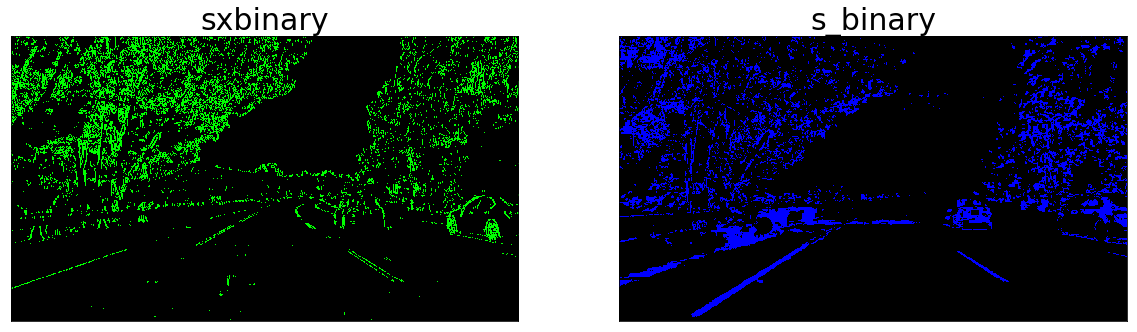

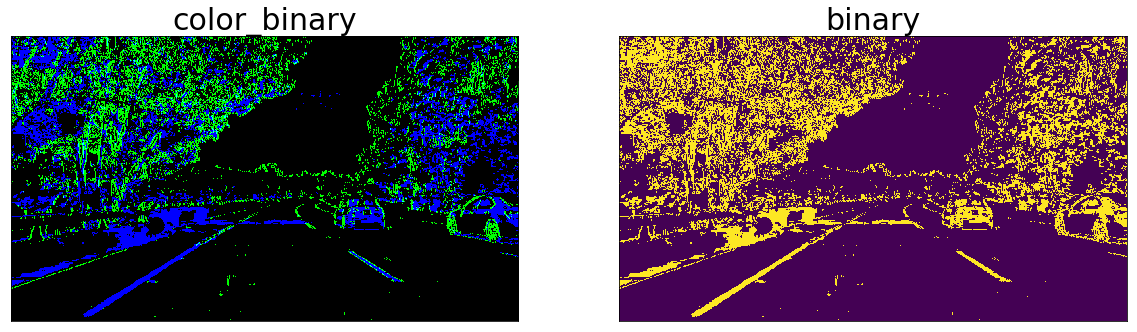

In [4]:
def undistort(img, mtx, dist):
    undist_image = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_image

def filter_color_and_gradient(img, s_thresh=(120, 255), sx_thresh=(20, 255), l_thresh=(40,255)):
    img0 = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img0, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    color_binary = np.dstack(( np.zeros_like(sxbinary) , sxbinary, s_binary))

    binary = np.zeros_like(sxbinary)
    binary[   (s_binary == 1) | (sxbinary==1)] = 1
    #binary = 255*np.dstack((binary,binary,binary)).astype('uint8') 
 
    s_binary0 = np.dstack(( np.zeros_like(sxbinary) , np.zeros_like(sxbinary), s_binary))
    sxbinary0 = np.dstack(( np.zeros_like(sxbinary) , sxbinary, np.zeros_like(s_binary)))
    #s_binary[s_binary == 1] = 1
    #s_binary = 255*np.dstack((s_binary,s_binary,s_binary)).astype('uint8') 
    
    #sxbinary[l_binary == 1] = 1
    #sxbinary = 255*np.dstack((sxbinary,sxbinary,sxbinary)).astype('uint8') 
    
    return sxbinary0, s_binary0, color_binary, binary 

test_images = glob.glob('test_images/test5.jpg')

for idx, fname in enumerate(test_images):
    image = plt.imread(fname)
    undist_image = undistort(image, mtx, dist)
    sxbinary, s_binary, color_binary, binary = filter_color_and_gradient(undist_image)

    # Plot the result
    fig1 = plt.figure(figsize=(20, 6))
    subplot = fig1.add_subplot(1,2,1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('sxbinary', fontsize=30)
    subplot.imshow(sxbinary)

    subplot2 = fig1.add_subplot(1,2,2)
    subplot2.set_xticks([])
    subplot2.set_yticks([])
    subplot2.set_title('s_binary', fontsize=30)
    subplot2.imshow(s_binary)
    
    fig2 = plt.figure(figsize=(20, 6))
    subplot3 = fig2.add_subplot(1,2,1)
    subplot3.set_xticks([])
    subplot3.set_yticks([])
    subplot3.set_title('color_binary', fontsize=30)
    subplot3.imshow(color_binary)

    subplot4 = fig2.add_subplot(1,2,2)
    subplot4.set_xticks([])
    subplot4.set_yticks([])
    subplot4.set_title('binary', fontsize=30)
    subplot4.imshow(binary)
    plt.show()

In [5]:
# Check undistorted images
with open('camera_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

undistorted_dir='output_images/undistorted/'

images = glob.glob('camera_cal/calibration*.jpg')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    image_name=os.path.split(fname)[1]
    write_name = undistorted_dir+image_name
    cv2.imwrite(write_name,dst)
    print("Save undistorted image:", write_name)
cv2.destroyAllWindows()

test_images = glob.glob('test_images/*.jpg')

for idx, fname in enumerate(test_images):
    img = cv2.imread(fname)
    dst = undistort(img, mtx, dist)
    image_name=os.path.split(fname)[1]
    write_name = undistorted_dir+image_name
    cv2.imwrite(write_name,dst)
    print("Save undistorted image:", write_name)
cv2.destroyAllWindows()

Save undistorted image: output_images/undistorted/calibration1.jpg
Save undistorted image: output_images/undistorted/calibration10.jpg
Save undistorted image: output_images/undistorted/calibration11.jpg
Save undistorted image: output_images/undistorted/calibration12.jpg
Save undistorted image: output_images/undistorted/calibration13.jpg
Save undistorted image: output_images/undistorted/calibration14.jpg
Save undistorted image: output_images/undistorted/calibration15.jpg
Save undistorted image: output_images/undistorted/calibration16.jpg
Save undistorted image: output_images/undistorted/calibration17.jpg
Save undistorted image: output_images/undistorted/calibration18.jpg
Save undistorted image: output_images/undistorted/calibration19.jpg
Save undistorted image: output_images/undistorted/calibration2.jpg
Save undistorted image: output_images/undistorted/calibration20.jpg
Save undistorted image: output_images/undistorted/calibration3.jpg
Save undistorted image: output_images/undistorted/c

In [6]:
def PerspectiveTransformBirdView(img,tobird=True):
    corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])    
    if tobird:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped, M, src, dst 

def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    
    shape = img.shape
    vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                      (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


In [7]:
def get_sliding_window(img,center_point,width, thresh=10000):
    """
    function: Mask the rectangle and line candidate specified by center, width, 
              and extract the sliding window.
    input: img,center_point,width,thresh
        img: binary 3 channel image
        center_point: center of window
        width: width of window
        [opt]thresh : threshold of histogram
    
    output: masked,center_point
        masked : a masked image of the same size. mask is a window centered at center_point
        center : the mean of all pixels found within the window
    """
    
    ny,nx,_ = img.shape
    mask  = np.zeros_like(img)
    if (center_point <= width/2): center_point = width/2
    if (center_point >= nx-width/2): center_point = nx-width/2
    
    left  = center_point - width/2
    right = center_point + width/2
    
    vertices = np.array([[(left,0),(left,ny), (right,ny),(right,0)]], dtype=np.int32)
    ignore_mask_color=(255,255,255)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked = cv2.bitwise_and(mask,img)

    hist = np.sum(masked[:,:,0],axis=0)
    if max(hist > thresh):
        center = np.argmax(hist)
    else:
        center = center_point
        
    return masked,center

def get_masked_lane_image(binary,center_point,width):
    """
    function: Integrate the sliding windows and take out the masked image.
    input: binary,center_point,width
        binary: binary 3 channel image
        center_point: center of window
        width: width of window
    
    output: window_image
        window_image : a masked image of the same size. mask is a window centered at center_point
    """
    n_zones=6
    ny,nx,nc = binary.shape
    zones = binary.reshape(n_zones,-1,nx,nc)
    zones = zones[::-1] # start from the bottom slice
    window,center = get_sliding_window(zones[0],center_point,width)
   
    for zone in zones[1:]:
        next_window,center = get_sliding_window(zone,center,width)
        window = np.vstack((next_window,window))
    
    return window

In [8]:
def find_lines(binary_warped):
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])     

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
     
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 120
    # Set minimum number of pixels found to recenter window
    minpix = 50
  
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
     
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
       
    return leftx, lefty, rightx, righty, out_img, histogram 

In [9]:
def Measuring_curvature(leftx, lefty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 35.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    lefty = lefty * ym_per_pix
    leftx = leftx * xm_per_pix 
    
    y_eval = np.max(lefty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty, leftx, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    # Now our radius of curvature is in meters
    
    # Calculate the line base position
    line_base_pos = left_fit_cr[0]*y_eval**2 + left_fit_cr[1]*y_eval + left_fit_cr[2]
    center_pos = 670 * xm_per_pix
    line_base_pos1 = line_base_pos - center_pos
    
    
    print(left_curverad, 'm')
    print(line_base_pos1, 'off centre')
    return left_curverad, line_base_pos1

In [10]:
from collections import deque

# Define a class to receive the characteristics of each line detection
class Line:
    def __init__(self,n=5):
        # length of queue to store data
        self.n = n
        #number of fits in buffer
        self.n_buffered = 0
        # was the line detected in the last iteration?
        self.detected = False  
        # average x values of the fitted line over the last n iterations
        self.best_xvals = None
        # polynomial coefficients averaged over the last n iterations
        self.best_coeffs = None  
        # xvals of the most recent fit
        self.current_fit_xvals = []  
        #polynomial coefficients for the most recent fit
        self.current_fit_coeffs = []          
        # x values of the last n fits of the line
        self.recent_fit_xvals = deque([],maxlen=n)
        # fit coeffs of the last n fits
        self.recent_fit_coeffs = deque([],maxlen=n)        
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #y values for line fit
        self.fit_yvals = np.linspace(0, 720, num=100) 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #distance in pixels of vehicle center from the line
        self.line_pix_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')        
                                            
    def get_fit_lines(self):
            return self.current_fit_xvals, self.fit_yvals

    def get_detect_lines(self):
            return self.allx, self.ally

    def get_last_x_pos(self):
        if self.detected==True:
            return self.line_pix_pos
        else:
            return None

    def get_best_fit_lines(self):
            return self.best_xvals, self.fit_yvals

    def get_driving_info(self):
            return self.radius_of_curvature, self.line_base_pos

    def sanity_checks_of_lines(self):
        flag = True
        maxdist = 2.8  # distance in meters from the lane
        if(abs(self.line_base_pos) > maxdist ):
            print('lane too far away')
            flag  = False        
        if(self.n_buffered > 0):
            relative_delta = self.diffs / self.best_coeffs
            # allow maximally this percentage of variation in the fit coefficients from frame to frame
            if not (abs(relative_delta)<np.array([0.7,0.5,0.15])).all():
                #print('fit coeffs too far off [%]',relative_delta)
                flag=False
                
        return flag
    
    def update(self,lane):

        self.ally,self.allx = (lane[:,:,0]>254).nonzero()

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 35.0/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        yvals = self.ally*ym_per_pix
        xvals = self.allx*xm_per_pix
        self.current_fit_coeffs = np.polyfit(yvals, xvals, 2)

        # Calculate xvals
        fit_yvals = self.fit_yvals * ym_per_pix       
        self.current_fit_xvals = (self.current_fit_coeffs[0]*fit_yvals**2 \
            + self.current_fit_coeffs[1]*fit_yvals + self.current_fit_coeffs[2]) / xm_per_pix
        
        y_eval = max(fit_yvals)

        # Calculate the new radii of curvature
        self.radius_of_curvature = ((1 + (2*self.current_fit_coeffs[0]*y_eval + self.current_fit_coeffs[1])**2)**1.5) \
                         /np.absolute(2*self.current_fit_coeffs[0])

        # Calculate the line base position
        line_base_pos = self.current_fit_coeffs[0]*y_eval**2 \
                        + self.current_fit_coeffs[1]*y_eval \
                        + self.current_fit_coeffs[2]
        self.line_pix_pos = line_base_pos / xm_per_pix
        center_pos = 670 * xm_per_pix
        self.line_base_pos = (line_base_pos - center_pos)

        # Calculate the diffrence coeffs
        if self.n_buffered > 0:
            self.diffs = self.current_fit_coeffs - self.best_coeffs
        else:
            self.diffs = np.array([0,0,0], dtype='float')                 

        if self.sanity_checks_of_lines():
            self.detected=True
            self.recent_fit_xvals.append(self.current_fit_xvals)
            self.recent_fit_coeffs.append(self.current_fit_coeffs)
            self.n_buffered = len(self.recent_fit_xvals)
            self.best_xvals = np.mean(self.recent_fit_xvals, axis=0)            
            self.best_coeffs = np.mean(self.recent_fit_coeffs, axis=0)
        else:
            self.detected=False
            self.best_xvals = self.current_fit_xvals            
            self.best_coeffs = self.current_fit_coeffs
                    
        return self.detected,self.n_buffered
    


In [11]:
# Define a class to receive the characteristics of each line detection
class Line0():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [12]:
def project_lane_lines(img,left_fitx,right_fitx,yvals):
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    unwarp,Minv,_,_ = PerspectiveTransformBirdView(img,tobird=False)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    undist = undistort(img, mtx, dist)    
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

In [13]:
def save_image(img,path,note):
    image_name = os.path.split(fname)[1]
    write_name = path+'/'+image_name.split('.')[0]+note+'.jpg'
    print(write_name)
    cv2.imwrite(write_name,img)

In [ ]:
def process_image(img):
    global left
    global right
    undist = undistort(img, mtx, dist)
    sxbinary, s_binary, color_binary, binary = filter_color_and_gradient(undist)
    birdView,_, src, dst = PerspectiveTransformBirdView(binary)
    warped_binary = region_of_interest(birdView)
    leftx, lefty, rightx, righty, out_img, histogram = find_lines(warped_binary)
    left_curvature = Measuring_curvature(leftx, lefty)
    right_curvature = Measuring_curvature(rightx, righty)
       
    save_image(undist,'process_image','_step_1_undistort')
     
    # Plot the result
    fig1 = plt.figure(figsize=(20, 6))
    subplot = fig1.add_subplot(1,2,1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('sxbinary', fontsize=30)
    subplot.imshow(sxbinary)

    subplot2 = fig1.add_subplot(1,2,2)
    subplot2.set_xticks([])
    subplot2.set_yticks([])
    subplot2.set_title('s_binary', fontsize=30)
    subplot2.imshow(s_binary)
    
    fig2 = plt.figure(figsize=(20, 6))
    subplot3 = fig2.add_subplot(1,2,1)
    subplot3.set_xticks([])
    subplot3.set_yticks([])
    subplot3.set_title('color_binary', fontsize=30)
    subplot3.imshow(color_binary)
    
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8') 
    subplot4 = fig2.add_subplot(1,2,2)
    subplot4.set_xticks([])
    subplot4.set_yticks([])
    subplot4.set_title('binary', fontsize=30)
    subplot4.imshow(binary)
    
    plt.show() 
    

    
    fig1.savefig('process_image/'+image_name.split('.')[0]+'_step2_1'+'.jpg')    
    fig2.savefig('process_image/'+image_name.split('.')[0]+'_step2_2'+'.jpg')   
    birdView = 255*np.dstack((birdView,birdView,birdView)).astype('uint8') 
    
    fig3 = plt.figure(figsize=(20, 6))
    subplot5 = fig3.add_subplot(1,2,1)
    subplot5.set_xticks([])
    subplot5.set_yticks([])
    subplot5.set_title('binary', fontsize=30)
    subplot5.imshow(binary)
        
    plt.scatter(src[0][0], src[0][1],  s=300, color='yellow')
    plt.scatter(src[1][0], src[1][1],  s=300, color='yellow')
    plt.scatter(src[2][0], src[2][1],  s=300, color='yellow')
    plt.scatter(src[3][0], src[3][1],  s=300, color='yellow')
    
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8') 
    subplot6 = fig3.add_subplot(1,2,2)
    subplot6.set_xticks([])
    subplot6.set_yticks([])
    subplot6.set_title('birdView', fontsize=30)
    subplot6.imshow(birdView)
    
    plt.scatter(dst[0][0], dst[0][1],  s=300, color='yellow')
    plt.scatter(dst[1][0], dst[1][1],  s=300, color='yellow')
    plt.scatter(dst[2][0], dst[2][1],  s=300, color='yellow')
    plt.scatter(dst[3][0], dst[3][1],  s=300, color='yellow')
    
    
    
     
    ##cv2.rectangle(img,(src[0],src[1]),(src[3],src[4]),(0,255,0), 3) 
    print(src)
    # Plot the result
    fig3 = plt.figure(figsize=(10, 12))
    subplot = fig3.add_subplot(2,1,1) 
    subplot.imshow(birdView)
    subplot2 = fig3.add_subplot(2,1,2)
    subplot2.plot(histogram) 
    fig3.savefig('process_image/'+image_name.split('.')[0]+'_step3_birdView_histogram'+'.jpg')
     
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)     
    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    fig4 = plt.figure(figsize=(10, 12))
    subplot = fig4.add_subplot(2,1,1) 
    subplot.imshow(out_img)
    subplot2 = fig4.add_subplot(2,1,2, sharex=subplot)
    subplot2.imshow(out_img)
    subplot2.plot(left_fitx, ploty, color='yellow')
    subplot2.plot(right_fitx, ploty, color='yellow')
    fig4.savefig('process_image/'+image_name.split('.')[0]+'_step4_1'+'.jpg')
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

      
    result = project_lane_lines(img,left_fitx,right_fitx,ploty)
    fig5 = plt.figure(figsize=(10, 6)) 
    subplot = fig5.add_subplot(1,1,1) 
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(result)
    
 
               
               
       
    #fig.savefig('process_image/'+image_name.split('.')[0]+'_step6_find_lines'+'.jpg', dpi=fig.dpi)
    #save_image(result,'process_image','_step7_result')

E:\Users\ALAN\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


402737.834912 m
-1.66891157162 off centre
8999.04249675 m
1.57062376036 off centre
process_image/straight_lines1_step_1_undistort.jpg


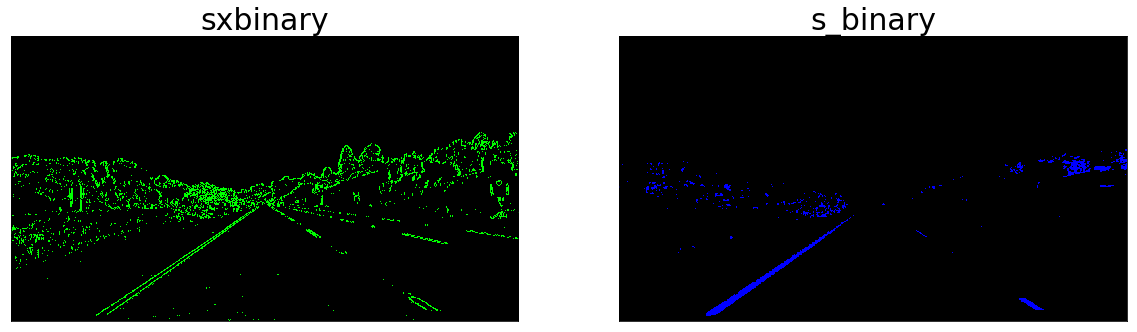

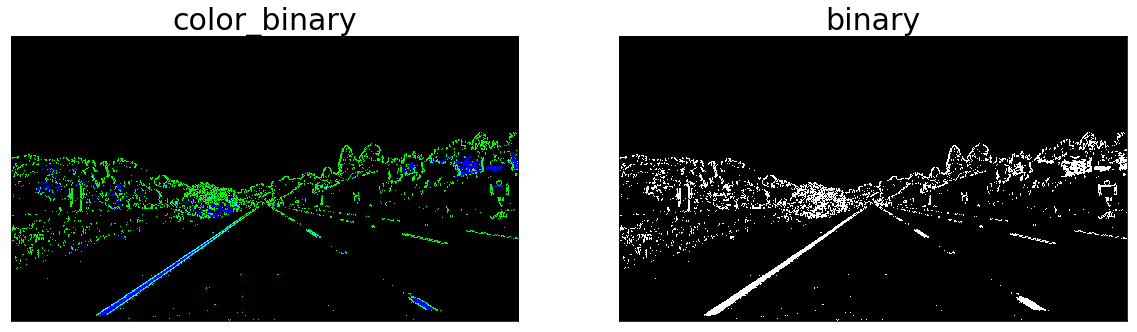

[[  190.   720.]
 [  589.   457.]
 [  698.   457.]
 [ 1145.   720.]]
4331.84425333 m
-1.63560621706 off centre
17554.6701349 m
1.57002164016 off centre
process_image/straight_lines2_step_1_undistort.jpg


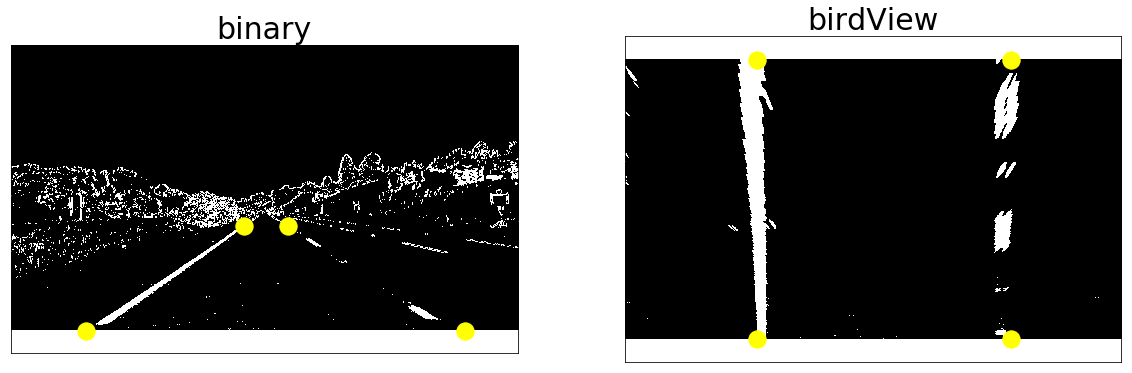

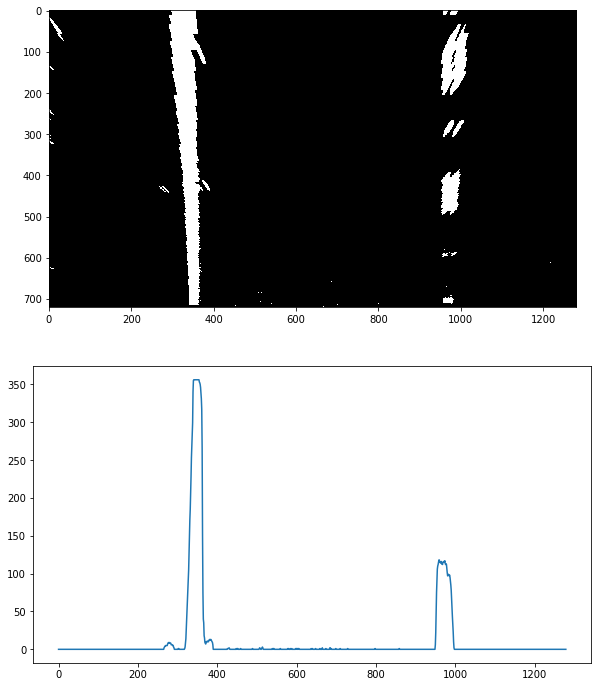

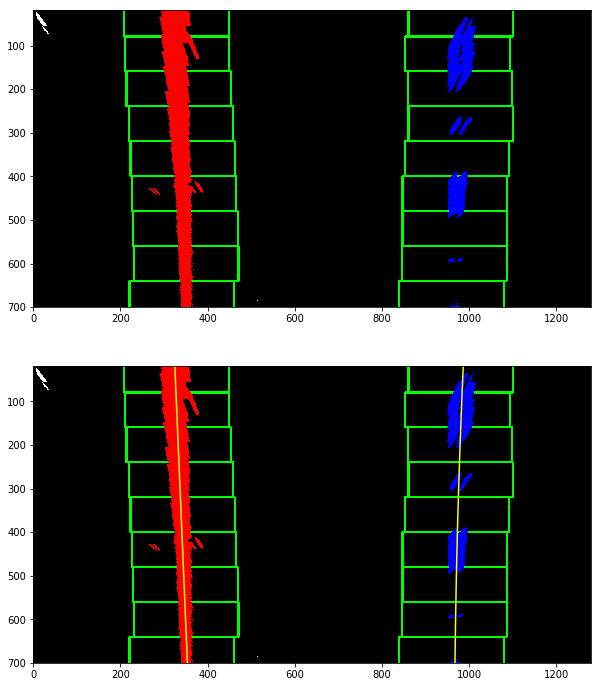

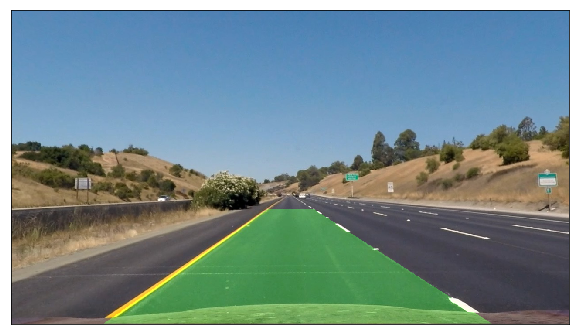

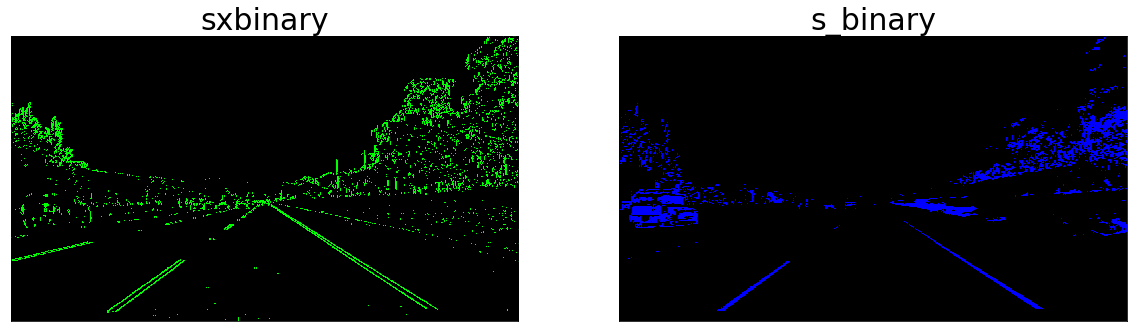

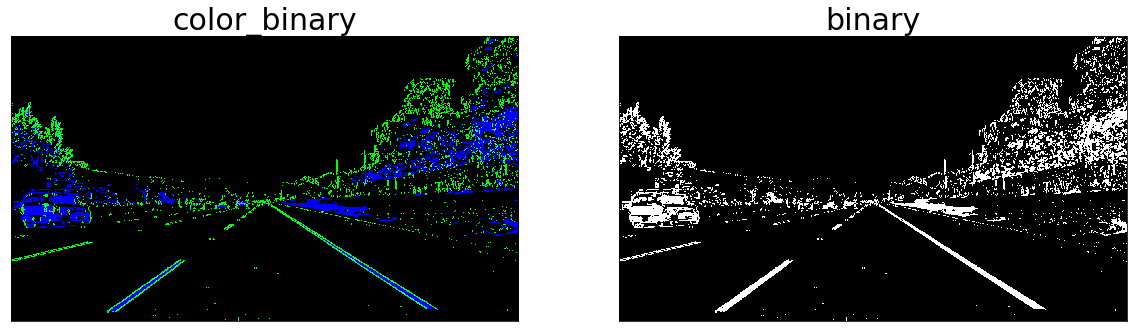

[[  190.   720.]
 [  589.   457.]
 [  698.   457.]
 [ 1145.   720.]]
1272.88994987 m
-1.5627830389 off centre
1153.22903441 m
1.75462686554 off centre
process_image/test1_step_1_undistort.jpg


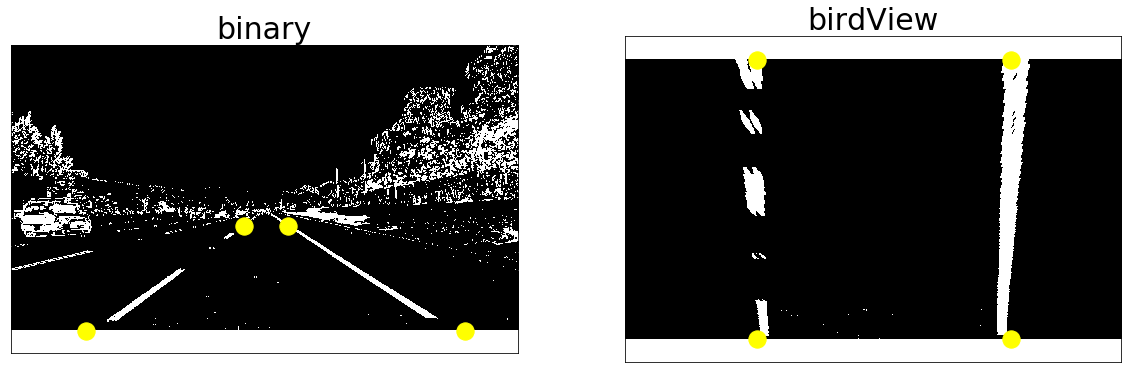

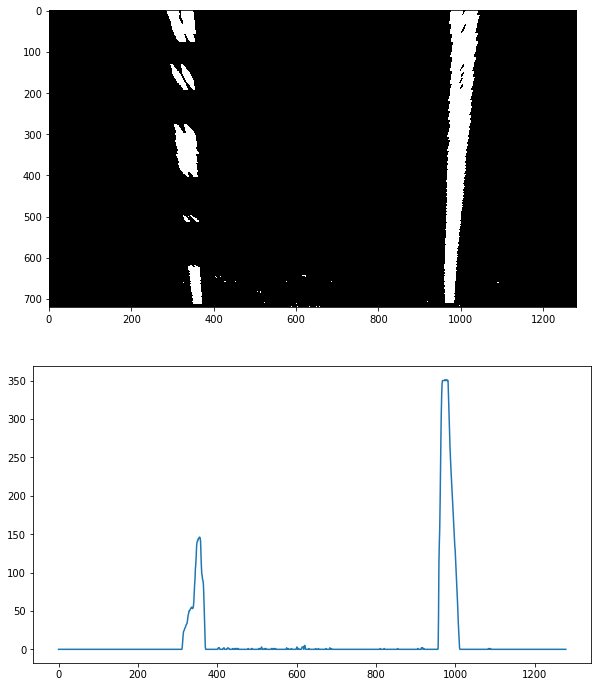

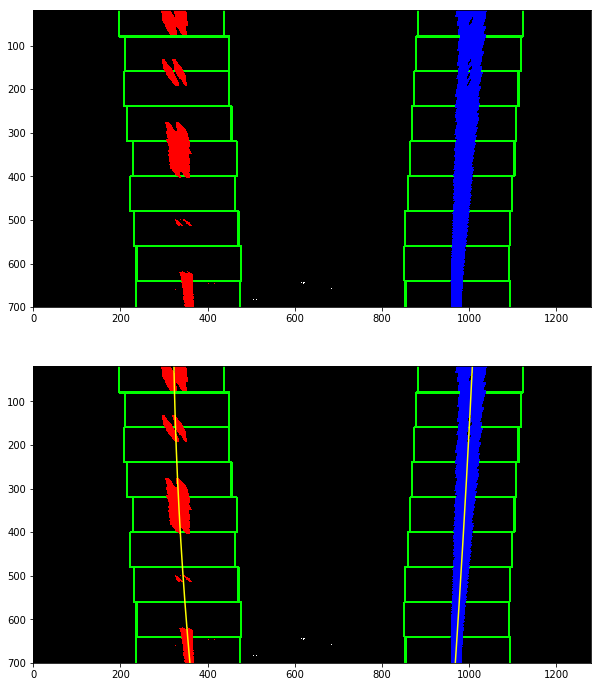

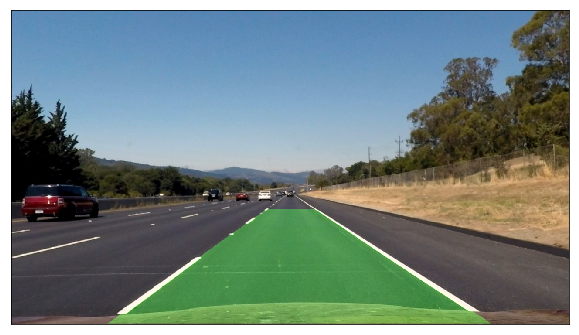

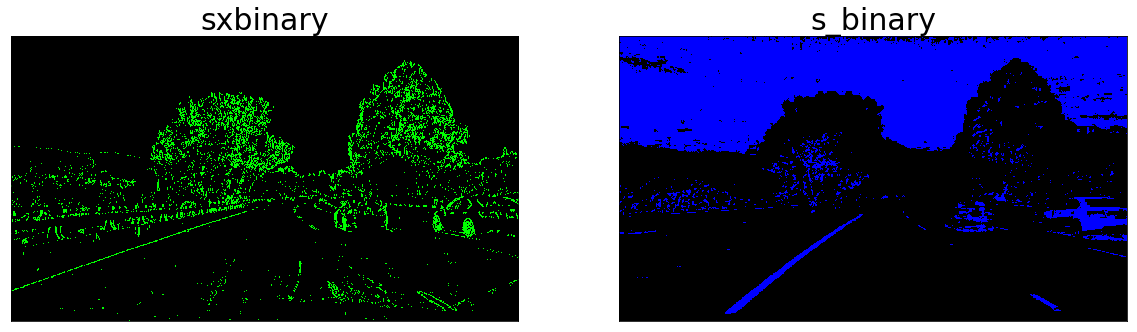

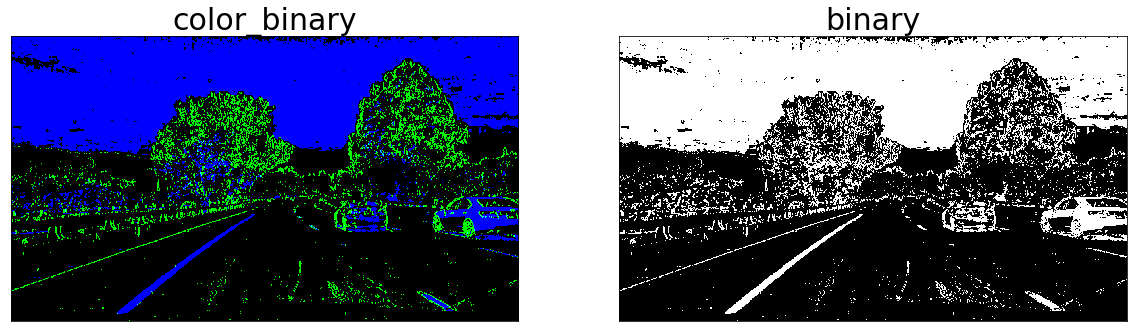

[[  190.   720.]
 [  589.   457.]
 [  698.   457.]
 [ 1145.   720.]]
831.240842646 m
-1.37561557252 off centre
583.051879034 m
1.73948125016 off centre
process_image/test2_step_1_undistort.jpg


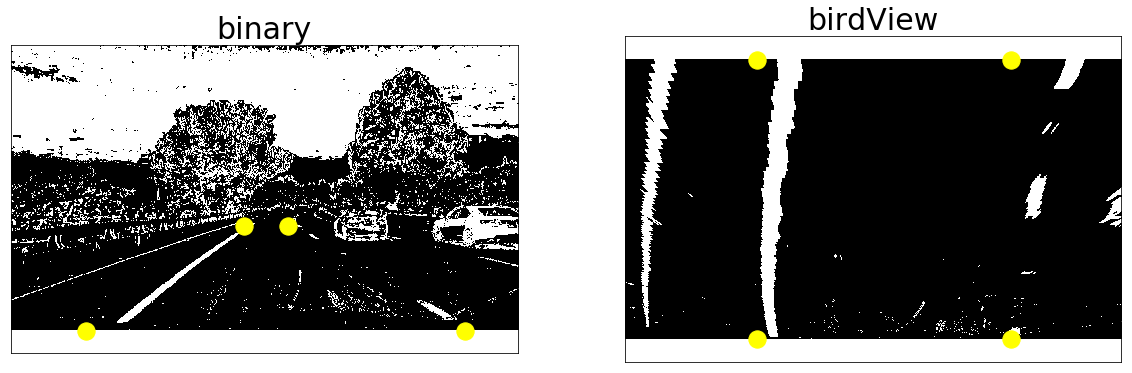

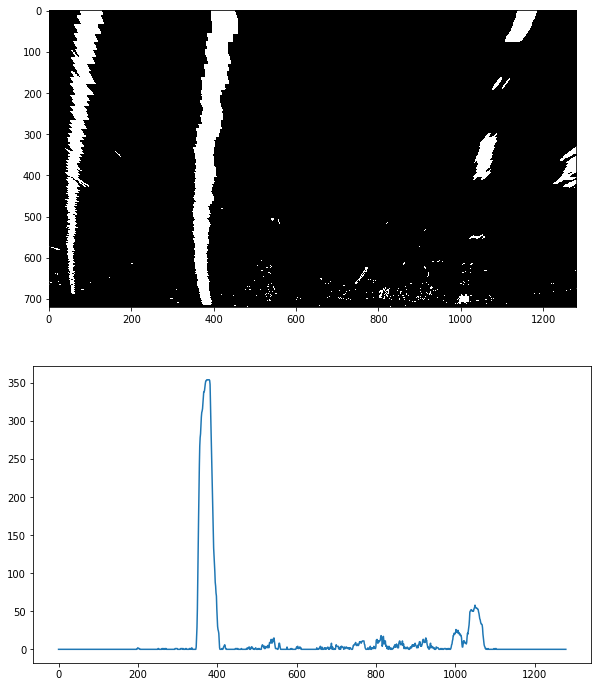

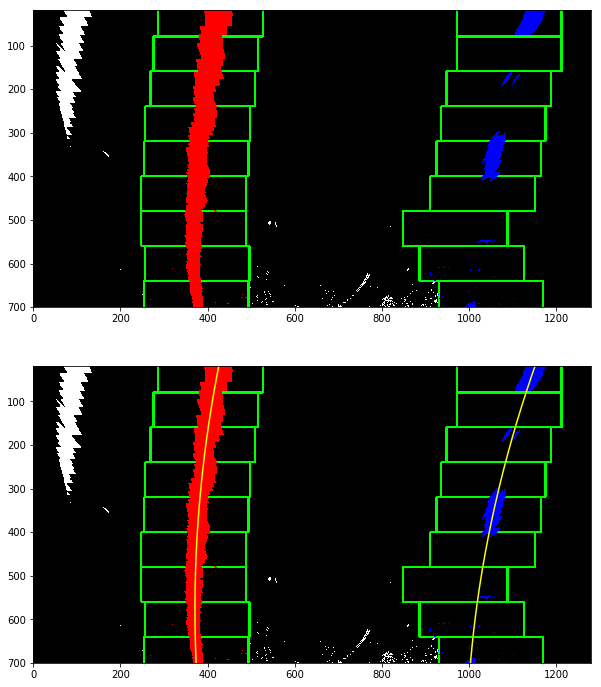

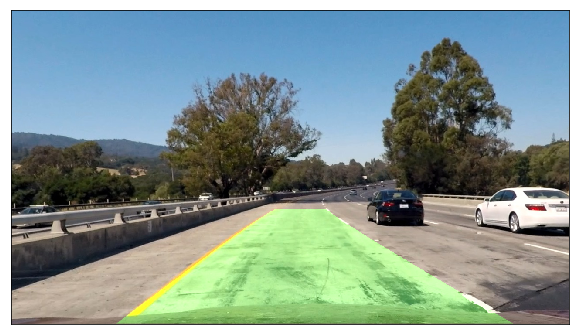

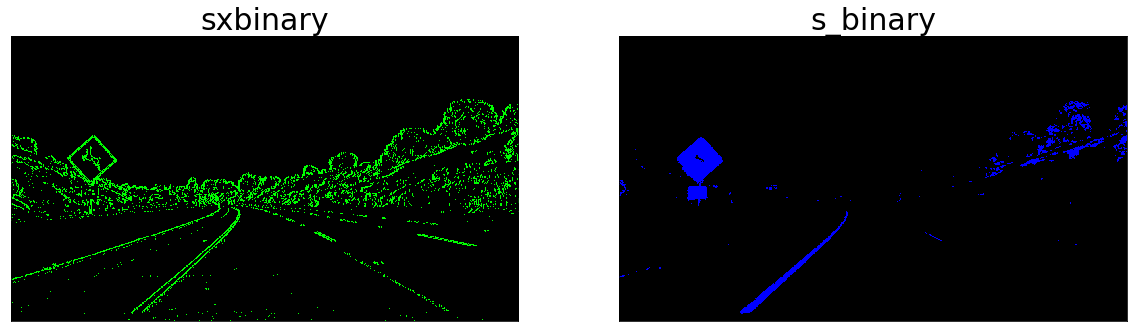

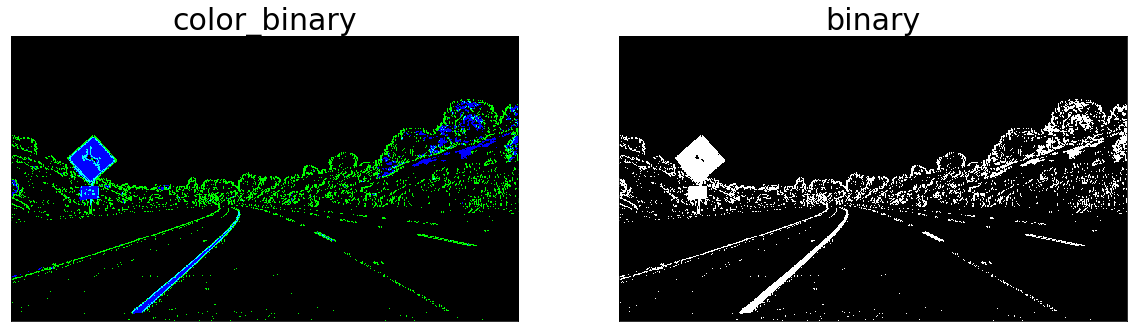

[[  190.   720.]
 [  589.   457.]
 [  698.   457.]
 [ 1145.   720.]]
1272.81284545 m
-1.57821176413 off centre
967.595600272 m
1.71234277052 off centre
process_image/test3_step_1_undistort.jpg


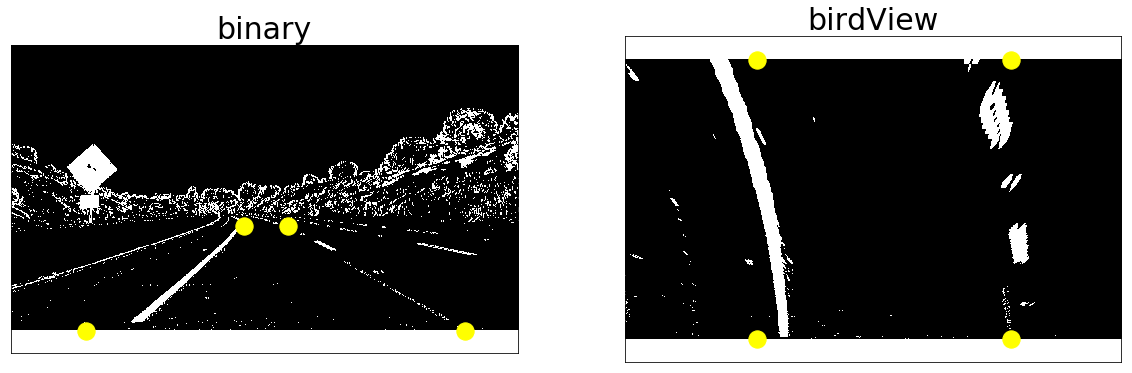

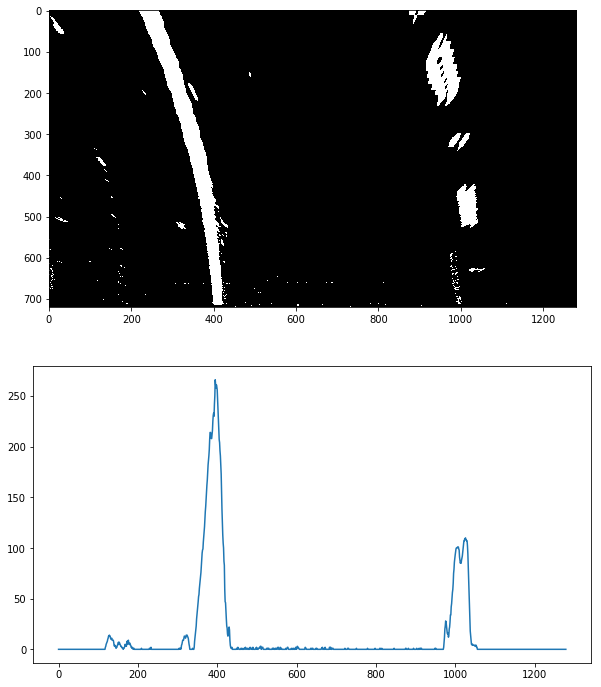

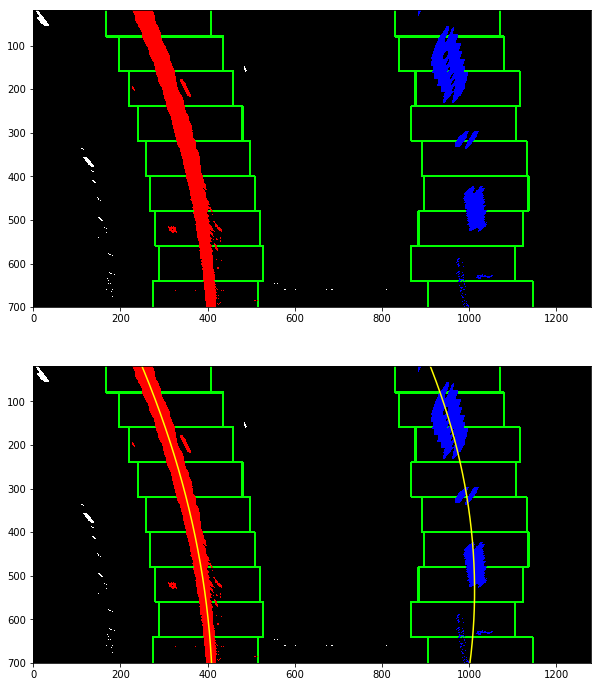

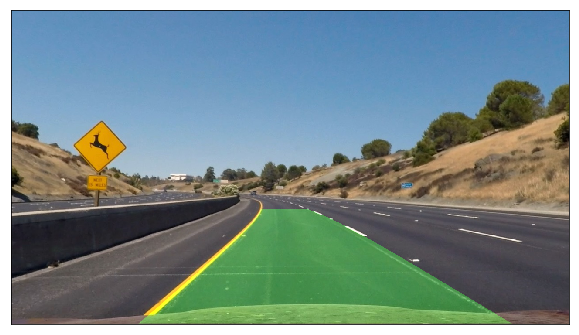

In [ ]:
for idx, fname in enumerate(test_images):
    img = plt.imread(fname)
    dst = process_image(img)